In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1
from matplotlib.patches import Wedge
import pandas as pd  # 导入 pandas 库

In [59]:
# 定义物理参数
c = 1500  # 声速，单位：m/s
rho0 = 1000  # 介质密度，单位：kg/m^3
f = 4e6  # 频率，单位：Hz
k = 2 * np.pi * f / c  # 波数
w = 2 * np.pi * f  # 角频率
u = 1  # 质点振动速度

In [60]:
# 定义环形相控阵参数
m = 10  # 圆环个数
lambda_ = c / f  # 波长
R_max = 25e-3  # 中心阵元到最大辐射圆环中心的距离，单位：m
F = 0.01  # 聚焦焦距，单位：m
n = 0.6 #(m - 1) / m  # 圆环间距与波长的倍数系数
delta_d = n * lambda_  # 圆环之间的间距

In [61]:
a1_list = []  # 存储每个圆环的a1值
a2_list = []  # 存储每个圆环的a2值
all_data = []  # 用于存储所有 m 值对应的圆环阵列数据


In [62]:
def save_annular_array_parameters(m):
    data = {
        'm值': [m] * m,  # 添加 m 值列
        '环编号': [i + 1 for i in range(m)],
        '内径 (mm)': [f'{a1*1000:.6f}' for a1 in a1_list],
        '外径 (mm)': [f'{a2*1000:.6f}' for a2 in a2_list]
    }
    df = pd.DataFrame(data)
    all_data.append(df)

    # 合并所有 DataFrame
    combined_df = pd.concat(all_data, ignore_index=True)

    # 保存到同一个 CSV 文件
    csv_file_path = 'annular_array_parameters_all.csv'
    combined_df.to_csv(csv_file_path, index=False)
    print(f"所有 m 值对应的圆环阵列参数已保存到 {csv_file_path}")


In [63]:
# 封装计算等面积圆环内外径的代码为函数
def calculate_annular_radii(R_max, m, delta_d):
    total_area = np.pi * R_max ** 2
    ring_area = (total_area-(m-1)*2*np.pi*R_max/2*delta_d) / m
    for i in range(m):
        if i == 0:
            a1 = 0
        else:
            a1 = a2_list[i - 1] + delta_d
        a2 = np.sqrt(a1 ** 2 + ring_area / np.pi)
        a2_list.append(a2)
        a1_list.append(a1)
    save_annular_array_parameters(m)
    return a1_list, a2_list

In [64]:
# 定义颜色列表
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

In [65]:
# 封装绘制圆环阵列的代码为函数
def plot_annular_array(inner_radii, outer_radii, max_diameter, gap, colors):
    fig, ax = plt.subplots()
    for i, (a1, a2) in enumerate(zip(inner_radii, outer_radii)):
        # 使用 Wedge 绘制中间有填充的环形
        ring = Wedge((0, 0), a2, 0, 360, width=(a2 - a1))
        # 从颜色列表中选取颜色进行填充
        color = colors[i % len(colors)]
        ring.set_facecolor(color)
        ring.set_edgecolor(color)
        ax.add_artist(ring)

        # 计算圆环面积
        area = np.pi * (a2**2 - a1**2)*1e6
        # 确定标注位置（圆环中心角度位置）
        label_r = (a1 + a2) / 2
        label_theta = 45  # 角度可以根据需要调整
        label_x = label_r * np.cos(np.radians(label_theta))
        label_y = label_r * np.sin(np.radians(label_theta))
    # 显示面积标注
    ax.text(0, 0, f'area:{area:.2f}mm2', ha='center', va='center', color='white', fontsize=6)

    ax.set_xlim(-max_diameter  * 1.5, max_diameter  * 1.5)
    ax.set_ylim(-max_diameter  * 1.5, max_diameter  * 1.5)
    ax.set_aspect('equal')
    ax.set_title('Annular Array')
    plt.show()

所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv


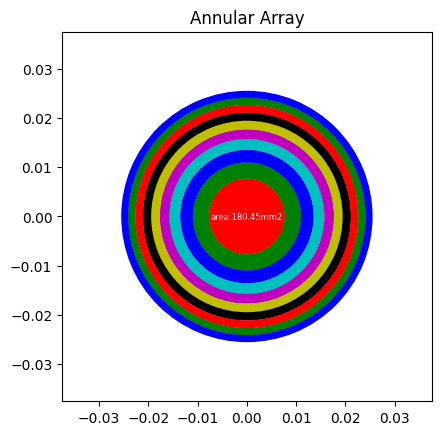

In [66]:
a1_list = []
a2_list = []
calculate_annular_radii(R_max,m,delta_d)
# 调用函数绘制圆环阵列
plot_annular_array(a1_list, a2_list, R_max, delta_d, colors)

In [67]:
# 定义声压公式，考虑分母为 0 的情况
def annular_array_pressure(F, r, theta, phi, t):
    p_total = 0
    epsilon = 1e-20  # 一个极小值，用于避免分母为 0
    for i in range(m):
        a1 = a1_list[i]
        a2 = a2_list[i]
        R_m = (a1 + a2) / 2  
        t_m = (np.sqrt(R_max ** 2 + F ** 2) - F - (np.sqrt(R_m ** 2 + F ** 2) - F)) / c
        denominator1 = k * a2 * np.cos(phi) * np.sin(theta)
        denominator2 = k * a1 * np.cos(phi) * np.sin(theta)

        # 计算 term1
        if np.abs(denominator1) < epsilon:
            # 当分母接近 0 时，使用贝塞尔函数极限性质
            term1 = a2 / 2
        else:
            term1 = (a2 ** 2 * j1(k * a2 * np.cos(phi) * np.sin(theta))) / denominator1

        # 计算 term2
        if np.abs(denominator2) < epsilon:
            # 当分母接近 0 时，使用贝塞尔函数极限性质
            term2 = a1 / 2
        else:
            term2 = (a1 ** 2 * j1(k * a1 * np.cos(phi) * np.sin(theta))) / denominator2

        p = (1j * k * rho0 * c * u / r) * (term1 - term2) * np.exp(1j * (2 * np.pi * f * t_m - k * r))
        p_total += p
    return p_total

In [68]:
# 定义评价声压旁瓣和主瓣的平均函数
def evaluate_sidelobe_mainlobe(pressure_values):
    # 找到最大声压值及其索引
    num = len(pressure_values)
    max_pressure = max(pressure_values)
    max_index = pressure_values.index(max_pressure)
    print("Mid num:",num/2, "max index:",max_index)

    if max_index < num / 2:
        max_index = int(num / 2)

    # 简单假设主瓣是最大声压值左右各 5 个点的范围，可根据实际情况调整
    mainlobe_start = max(0, max_index - 5)
    mainlobe_end = min(len(pressure_values), max_index + 5)

    # 计算主瓣的平均声压
    mainlobe_pressures = pressure_values[mainlobe_start:mainlobe_end]
    mainlobe_avg = np.mean(mainlobe_pressures)

    # 找出所有峰值点
    peaks = []
    for i in range(1, len(pressure_values) - 1):
        if pressure_values[i] > pressure_values[i - 1] and pressure_values[i] > pressure_values[i + 1]:
            peaks.append(pressure_values[i])

    # 排除主瓣范围内的峰值
    sidelobe_peaks = []
    for peak in peaks:
        peak_index = pressure_values.index(peak)
        if peak_index < mainlobe_start or peak_index >= mainlobe_end:
            sidelobe_peaks.append(peak)

    # 计算旁瓣平均声压
    sidelobe_avg = np.mean(sidelobe_peaks) if sidelobe_peaks else 0


    return mainlobe_avg, sidelobe_avg

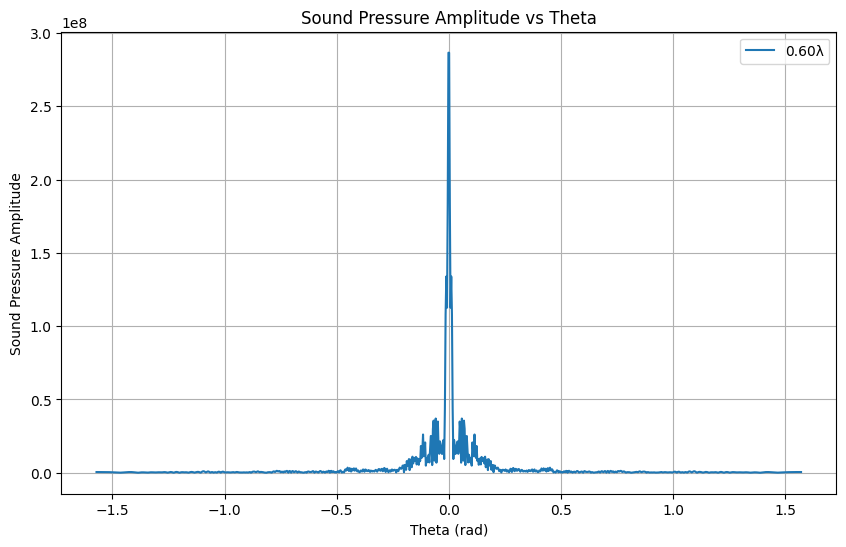

Mid num: 500.0 max index: 500
主瓣平均声压: 164897239.854495
旁瓣平均声压: 4621135.017304


In [69]:
# 定义 theta 范围
theta_values = np.linspace(-np.pi/2 , np.pi /2, 1000)

# 固定 r、phi 和 t 的值
r = F  # 可根据需要调整 r 的值
phi = 0
t = 0

plt.figure(figsize=(10, 6))   

# 计算每个 theta 对应的声压幅值
pressure_values = []
for theta in theta_values:
    pressure = annular_array_pressure(F, r, theta, phi, t)
    pressure_amplitude = np.abs(pressure)
    pressure_values.append(pressure_amplitude)
    # 绘制声压随 theta 的变化曲线    
plt.plot(theta_values, pressure_values,label='%.2fλ'%n)
plt.xlabel('Theta (rad)')
plt.ylabel('Sound Pressure Amplitude')
plt.title('Sound Pressure Amplitude vs Theta')
plt.legend()
plt.grid(True)
plt.show()    

# 调用评价函数
mainlobe_avg, sidelobe_avg = evaluate_sidelobe_mainlobe(pressure_values)
print(f"主瓣平均声压: {mainlobe_avg:.6f}")
print(f"旁瓣平均声压: {sidelobe_avg:.6f}")

所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv
Mid num: 500.0 max index: 497
主瓣平均声压: 94407446.928804
旁瓣平均声压: 5337431.094438
所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv
Mid num: 500.0 max index: 503
主瓣平均声压: 77802370.958511
旁瓣平均声压: 5775607.322998
所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv
Mid num: 500.0 max index: 503
主瓣平均声压: 84632720.793618
旁瓣平均声压: 5776252.313912
所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv
Mid num: 500.0 max index: 496
主瓣平均声压: 105080480.435456
旁瓣平均声压: 5306753.242957
所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv
Mid num: 500.0 max index: 496
主瓣平均声压: 105790747.334055
旁瓣平均声压: 5663645.881120
所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv
Mid num: 500.0 max index: 503
主瓣平均声压: 88022736.826898
旁瓣平均声压: 5441784.777971
所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv
Mid num: 500.0 max index: 503
主瓣平均声压: 92153457.466620
旁瓣平均声压: 5380016.975508
所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv
Mid num: 500.0 max index: 503
主瓣平均声

<Figure size 1000x600 with 0 Axes>

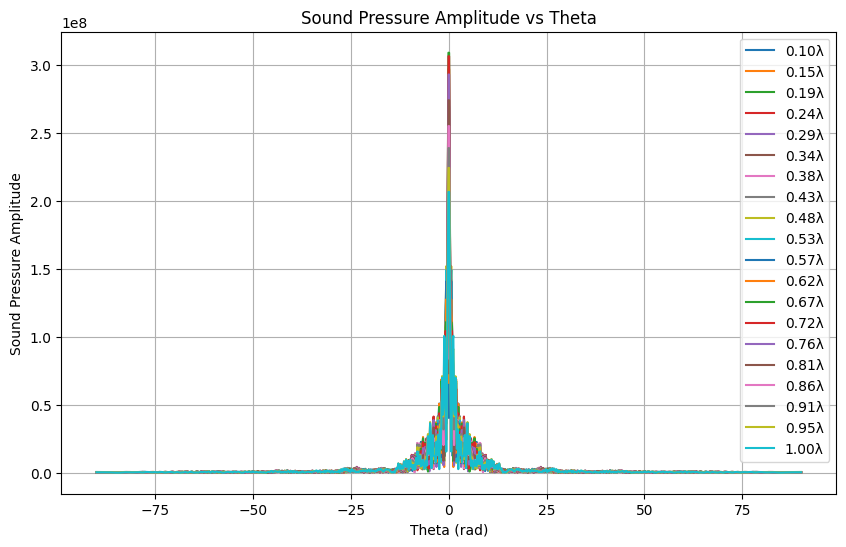

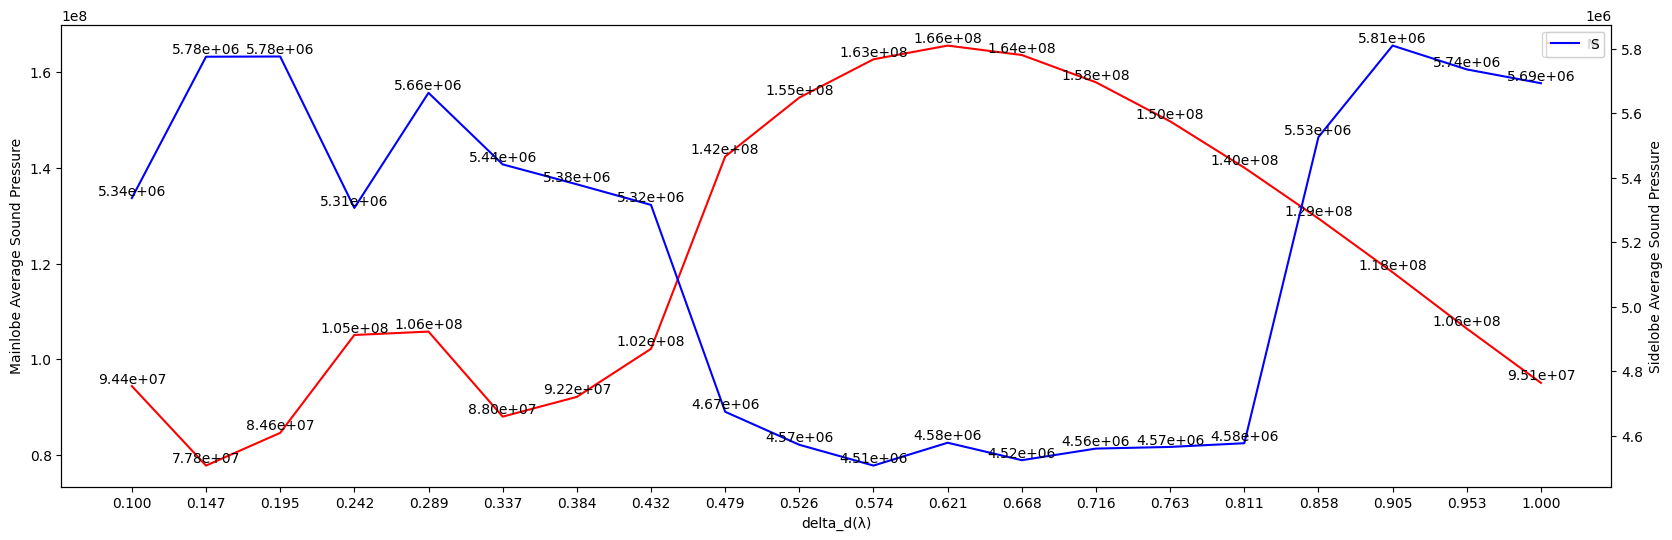

In [70]:
plt.figure(figsize=(10, 6))   

# 定义 delta_d 数组，范围从 0.1 * lambda_ 到 2 * lambda_
delta_d_array = np.linspace(0.1 * lambda_, 1 * lambda_, 20)

a1_list = []
a2_list = []
mainlobe_avg_list = []
sidelobe_avg_list = []

# 开始绘制不同 delta_d 下的声压曲线
plt.figure(figsize=(10, 6))
# 设置图片清晰度
plt.rcParams['figure.dpi'] = 100

for del_d in delta_d_array:
    a1_list = []
    a2_list = []
    # 调用函数计算圆环内外径
    a1_list, a2_list = calculate_annular_radii(R_max, m, del_d)
    # 调用函数绘制圆环阵列
    # plot_annular_array(a1_list, a2_list, R_max, delta_d, colors)
    # 计算每个 theta 对应的声压幅值
    pressure_values = []
    for theta in theta_values:
        pressure = annular_array_pressure(F, r, theta, phi, t)
        pressure_amplitude = np.abs(pressure)
        pressure_values.append(pressure_amplitude)
    # 将 theta 从弧度转换为角度
    theta_values_deg = np.rad2deg(theta_values)
    # 绘制声压随 theta（角度）的变化曲线
    plt.plot(theta_values_deg, pressure_values, label='{:.2f}λ'.format(del_d/lambda_))
    # 调用评价函数
    mainlobe_avg, sidelobe_avg = evaluate_sidelobe_mainlobe(pressure_values)
    mainlobe_avg_list.append(mainlobe_avg)
    sidelobe_avg_list.append(sidelobe_avg)
    print(f"主瓣平均声压: {mainlobe_avg:.6f}")
    print(f"旁瓣平均声压: {sidelobe_avg:.6f}")
plt.xlabel('Theta (rad)')
plt.ylabel('Sound Pressure Amplitude')
plt.title('Sound Pressure Amplitude vs Theta')
plt.legend()
plt.grid(True)
plt.show() 


# 绘制主瓣平均声压柱状图
x_pos = np.arange(len(delta_d_array))
x_data = [f'{v:.3f}' for v in delta_d_array / lambda_]

fig,ax1 = plt.subplots()
fig.set_size_inches(20, 6)
ax1.set_xticks(x_pos, x_data)

ax2 = ax1.twinx()
ax1.plot(x_pos, mainlobe_avg_list,color='red')
for i, v in enumerate(mainlobe_avg_list):
    ax1.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
ax1.set_xlabel('delta_d(λ)')
ax1.set_ylabel('Mainlobe Average Sound Pressure')
ax1.legend('Mainlobe')
# plt.xlabel('delta_d')
# plt.title('Mainlobe Average Sound Pressure')    
# 显示图表
# plt.show()
    
# plt.figure(figsize=(20, 6))    
# plt.xticks(x_pos, x_data)
ax2.plot(x_pos, sidelobe_avg_list,color='blue')
ax2.set_ylabel('Sidelobe Average Sound Pressure')
for i, v in enumerate(sidelobe_avg_list):
    ax2.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
ax2.legend('Sidelobe')    
# plt.xlabel('delta_d')
# plt.title('Sidelobe Average Sound Pressure')
# 显示图表
plt.show()

所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv
Mid num: 500.0 max index: 503
主瓣平均声压: 95013584.938111
旁瓣平均声压: 5452351.862985
所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv
Mid num: 500.0 max index: 510
主瓣平均声压: 42070347.437828
旁瓣平均声压: 4938699.440714
所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv
Mid num: 500.0 max index: 500
主瓣平均声压: 141792041.264961
旁瓣平均声压: 3805412.680418
所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv
Mid num: 500.0 max index: 500
主瓣平均声压: 39422693.239171
旁瓣平均声压: 4040357.194937
所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv
Mid num: 500.0 max index: 500
主瓣平均声压: 98760065.481314
旁瓣平均声压: 3582336.023962
所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv
Mid num: 500.0 max index: 500
主瓣平均声压: 59527923.293081
旁瓣平均声压: 3332852.266966
所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv
Mid num: 500.0 max index: 500
主瓣平均声压: 60837984.395044
旁瓣平均声压: 3523558.142691
所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv
Mid num: 500.0 max index: 500
主瓣平均声压

<Figure size 1000x600 with 0 Axes>

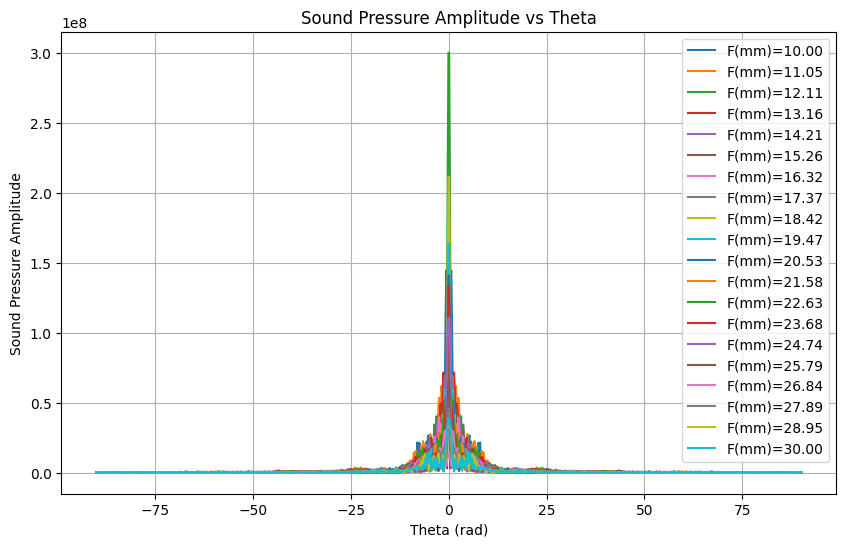

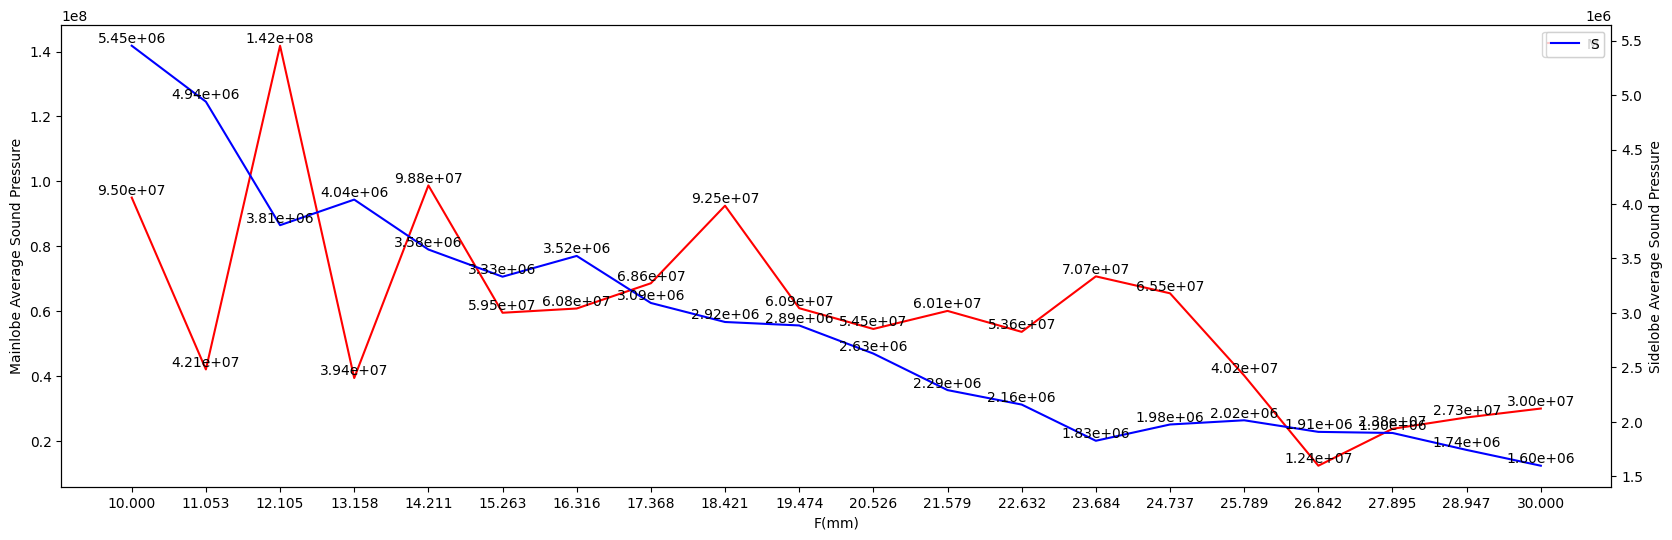

In [71]:
plt.figure(figsize=(10, 6))   

# 定义 delta_d 数组，范围从 0.1 * lambda_ 到 2 * lambda_
F_array = np.linspace(10e-3, 30e-3, 20)

a1_list = []
a2_list = []
mainlobe_avg_list = []
sidelobe_avg_list = []

delta_d = lambda_ *2/5
# 开始绘制不同 delta_d 下的声压曲线
plt.figure(figsize=(10, 6))
# 设置图片清晰度
plt.rcParams['figure.dpi'] = 100

for F_d in F_array:
    a1_list = []
    a2_list = []
    # 调用函数计算圆环内外径
    a1_list, a2_list = calculate_annular_radii(R_max, m, delta_d)
    # 调用函数绘制圆环阵列
    # plot_annular_array(a1_list, a2_list, R_max, delta_d, colors)
    # 计算每个 theta 对应的声压幅值
    pressure_values = []
    for theta in theta_values:
        pressure = annular_array_pressure(F_d, F_d, theta, phi, t)
        pressure_amplitude = np.abs(pressure)
        pressure_values.append(pressure_amplitude)
    # 将 theta 从弧度转换为角度
    theta_values_deg = np.rad2deg(theta_values)
    # 绘制声压随 theta（角度）的变化曲线
    plt.plot(theta_values_deg, pressure_values, label='F(mm)={:.2f}'.format(F_d*1000))
    # 调用评价函数
    mainlobe_avg, sidelobe_avg = evaluate_sidelobe_mainlobe(pressure_values)
    mainlobe_avg_list.append(mainlobe_avg)
    sidelobe_avg_list.append(sidelobe_avg)
    print(f"主瓣平均声压: {mainlobe_avg:.6f}")
    print(f"旁瓣平均声压: {sidelobe_avg:.6f}")
plt.xlabel('Theta (rad)')
plt.ylabel('Sound Pressure Amplitude')
plt.title('Sound Pressure Amplitude vs Theta')
plt.legend()
plt.grid(True)
plt.show() 


# 绘制主瓣平均声压柱状图
x_pos = np.arange(len(F_array))
x_data = [f'{v:.3f}' for v in F_array*1e3]

fig,ax1 = plt.subplots()
fig.set_size_inches(20, 6)

ax1.set_xticks(x_pos, x_data)
ax1.plot(x_pos, mainlobe_avg_list,color='red')
for i, v in enumerate(mainlobe_avg_list):
    ax1.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
ax1.set_xlabel('F(mm)')
ax1.set_ylabel('Mainlobe Average Sound Pressure')
ax1.legend('Mainlobe')

ax2 = ax1.twinx()
ax2.plot(x_pos, sidelobe_avg_list,color='blue')
for i, v in enumerate(sidelobe_avg_list):
    ax2.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
ax2.set_ylabel('Sidelobe Average Sound Pressure')    
ax2.legend('Sidelobe')

plt.show()


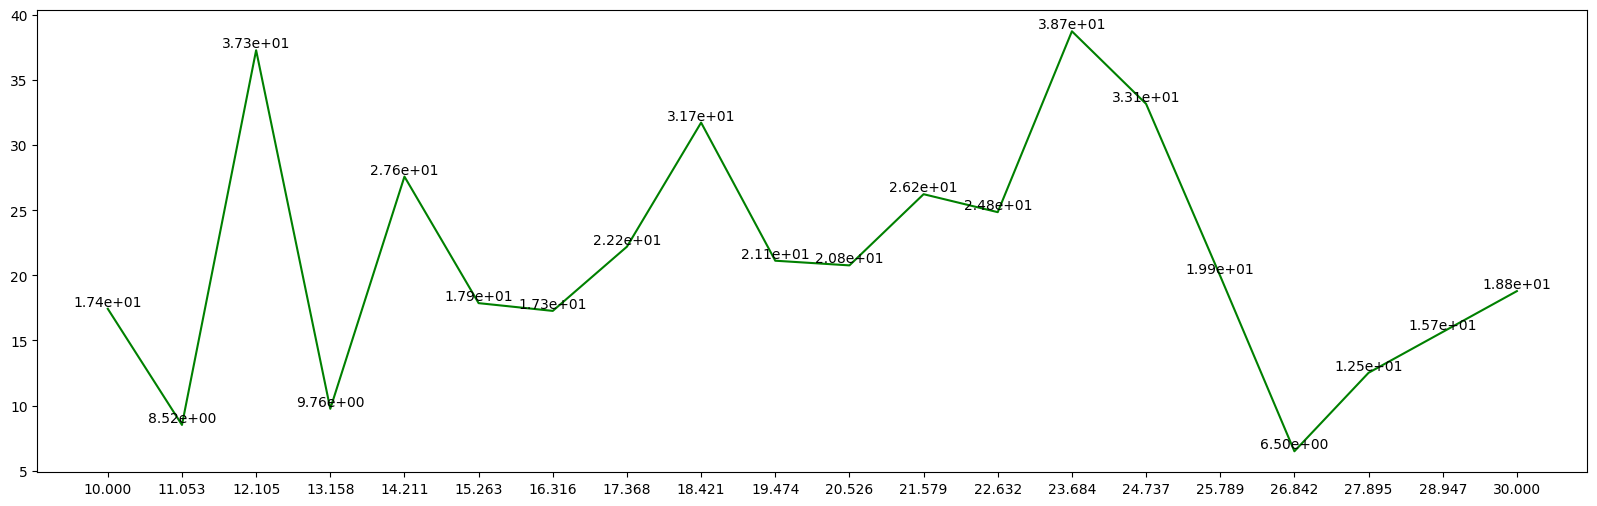

In [72]:
plt.figure(figsize=(20, 6))
plt.xticks(x_pos, x_data)
ratio = np.array(mainlobe_avg_list)/np.array(sidelobe_avg_list)
plt.plot(x_pos,ratio,color='green')
for i, v in enumerate(ratio):
    plt.text(x_pos[i], v, f'{v:.2e}', ha='center', va='bottom')
plt.show()

所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

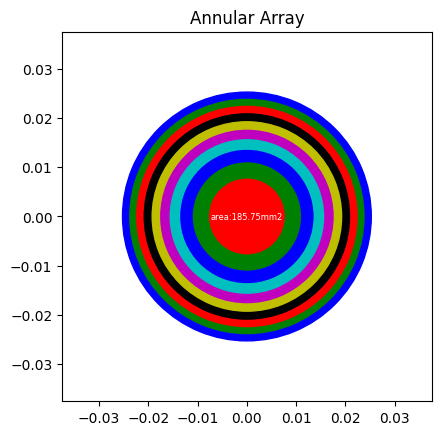

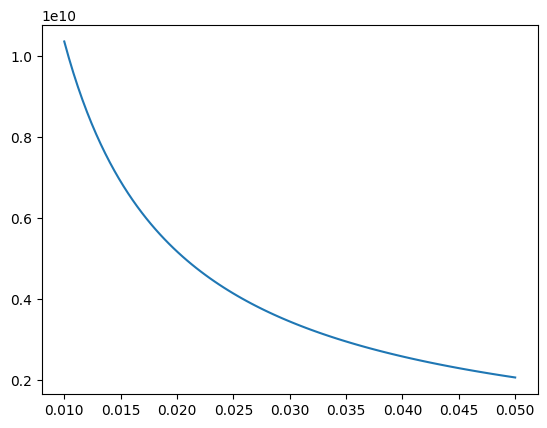

In [73]:
plt.figure(figsize=(10, 6))   

# 定义 delta_d 数组，范围从 0.1 * lambda_ 到 2 * lambda_
dis_array = np.linspace(F, 5*F, 100)

a1_list = []
a2_list = []

delta_d = lambda_ *2/5
# 开始绘制不同 delta_d 下的声压曲线
plt.figure(figsize=(10, 6))
# 设置图片清晰度
plt.rcParams['figure.dpi'] = 100
# 调用函数计算圆环内外径
a1_list, a2_list = calculate_annular_radii(R_max, m, delta_d)
# 调用函数绘制圆环阵列
plot_annular_array(a1_list, a2_list, R_max, delta_d, colors)
# 计算每个 theta 对应的声压幅值
pressure_values = []
    
for dis in dis_array:
    pressure = annular_array_pressure(F, dis, 0, 0, t)
    pressure_amplitude = np.abs(pressure)
    pressure_values.append(pressure_amplitude)
plt.plot(dis_array, pressure_values)
plt.show() 

所有 m 值对应的圆环阵列参数已保存到 annular_array_parameters_all.csv


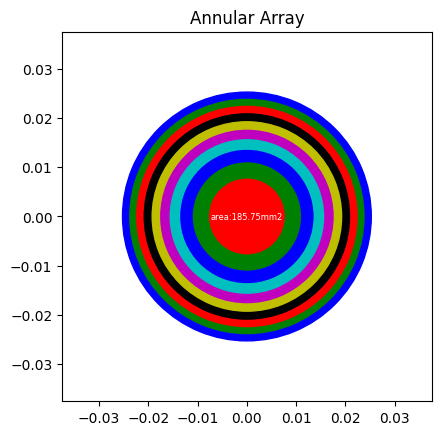

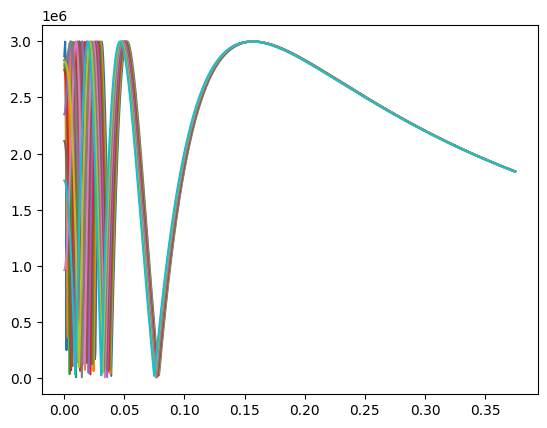

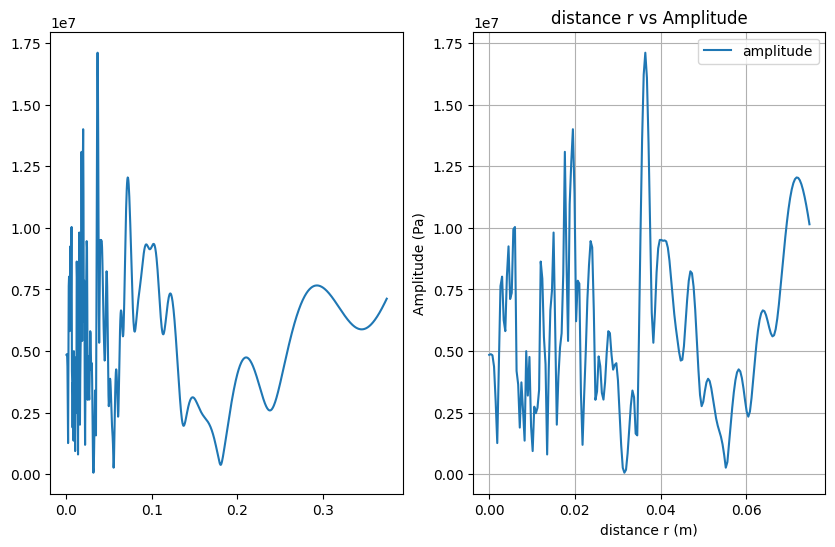

In [74]:
# 近场声压计算
# 计算相位延迟
def calculate_phase_delay(rho1, rho2, z, z_f):
    rho_avg = (rho1 + rho2) / 2
    h_f0 = np.sqrt(rho_avg**2 + z_f**2)
    h_f1 = np.sqrt(rho1**2 + z_f**2)
    h_f2 = np.sqrt(rho2**2 + z_f**2)
    phi1 = k * (h_f1 - h_f0)
    phi2 = k * (h_f2 - h_f0)
    return phi1, phi2
# 计算单个圆环的声压
def single_ring_pressure(z, rho1, rho2, phi1, phi2):
    p = rho0 * c * u * (np.exp(-1j * k * np.sqrt(rho1**2 + z**2) + 1j * phi1) -
                            np.exp(-1j * k * np.sqrt(rho2**2 + z**2) + 1j * phi2))
    return p
# 计算圆环阵列的总声压
def total_pressure(z):
    p_total = 0
    for i in range(len(a1_list)):
        rho1 = a1_list[i]
        rho2 = a2_list[i]
        phi1, phi2 = calculate_phase_delay(rho1, rho2, z, F)
        p_ring = single_ring_pressure(z, rho1, rho2, phi1, phi2)
        p_total += p_ring
    return p_total

r_values = np.linspace(0.1*lambda_, 1000*lambda_,1000)  # 不同的距离 r
pressure_amplitudes = []
a1_list = []
a2_list = []
# 调用函数计算圆环内外径
a1_list, a2_list = calculate_annular_radii(R_max, m, delta_d)
# 调用函数绘制圆环阵列
plot_annular_array(a1_list, a2_list, R_max, delta_d, colors)

for i in range(len(a1_list)):
    pressure_amplitudes = []
    for r in r_values:
        phi1, phi2 = calculate_phase_delay(a1_list[i], a2_list[i], r, F)
        pressure = single_ring_pressure(r, a1_list[i], a2_list[i],0,0)
        pressure_amplitude = np.abs(pressure)
        pressure_amplitudes.append(pressure_amplitude)
    plt.plot(r_values, pressure_amplitudes, label='amplitude')
plt.show()

pressure_amplitudes = []
for r in r_values:
    pressure = total_pressure(r)
    pressure_amplitude = np.abs(pressure)
    pressure_amplitudes.append(pressure_amplitude)
    
# 绘制声压幅值曲线
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(r_values, pressure_amplitudes, label='amplitude')
plt.subplot(1, 2, 2)
plt.plot(r_values[:200], pressure_amplitudes[:200], label='amplitude')
plt.xlabel('distance r (m)')
plt.ylabel('Amplitude (Pa)')
plt.title('distance r vs Amplitude')
plt.legend()
plt.grid(True)
plt.show()